In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Assuming that you have your joint angles and EIM data in X and the corresponding labels (joint angle and weight) in y.

# # Example data loading (replace this with your actual data loading code)
# # X and y should be NumPy arrays
# # X should have shape (num_samples, num_timesteps, num_features)
# # y should have shape (num_samples, num_output_features)

# # Generate example data (replace this with your actual data loading code)
# np.random.seed(42)
# num_samples = 1000
# num_timesteps = 10
# num_features = 2  # Replace with the actual number of features for joint angles and EIM data
# num_output_features = 2  # Replace with the actual number of output features (joint angle and weight)

# X = np.random.rand(num_samples, num_timesteps, num_features)
# y = np.random.rand(num_samples, num_output_features)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalize the data using Min-Max scaling
# scaler_x = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler_x.fit_transform(X_train.reshape(-1, num_features)).reshape(X_train.shape)
# X_test = scaler_x.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape)

# scaler_y = MinMaxScaler(feature_range=(0, 1))
# y_train = scaler_y.fit_transform(y_train)
# y_test = scaler_y.transform(y_test)

# # Build the GRU model
# model = Sequential()
# model.add(GRU(50, activation='relu', input_shape=(num_timesteps, num_features)))
# model.add(Dense(num_output_features, activation='linear'))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')

# # Make predictions on new data
# # Replace `new_data` with your actual new data
# new_data = np.random.rand(1, num_timesteps, num_features)
# scaled_new_data = scaler_x.transform(new_data.reshape(-1, num_features)).reshape(new_data.shape)
# prediction = model.predict(scaled_new_data)
# scaled_prediction = scaler_y.inverse_transform(prediction)
# print(f'Predicted values: {scaled_prediction}')

<h1>Import Libaries</h1>

In [61]:
# %pip install tensorflow
# %pip install pandas
# %pip install scikit-learn
# %pip install plotly
# %pip install scipy

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version:', tf.__version__)
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed, concatenate, Dot, Activation, Concatenate, Flatten # for creating layers inside the Neural Network

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.model_selection import train_test_split

# Visualization
import plotly
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

import scipy.io
from scipy.interpolate import interp1d
print('scipy: %s' % scipy.__version__) # print version

import matplotlib.pyplot as plt

import math

Tensorflow version: 2.14.0
pandas: 2.1.1
numpy: 1.26.0
sklearn: 1.3.1
plotly: 5.17.0
scipy: 1.11.3


<h1>Load Data</h1>

<h3>From several csv files</h3>

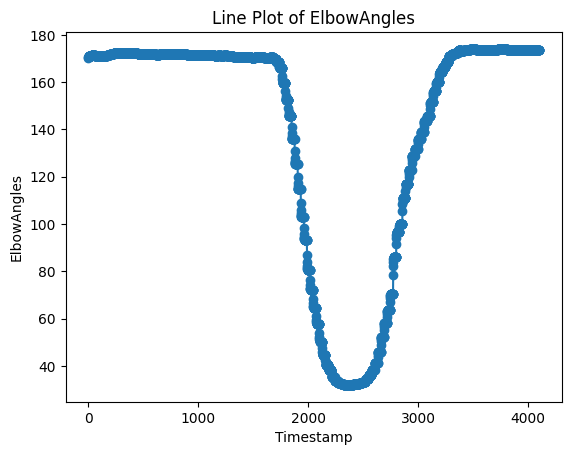

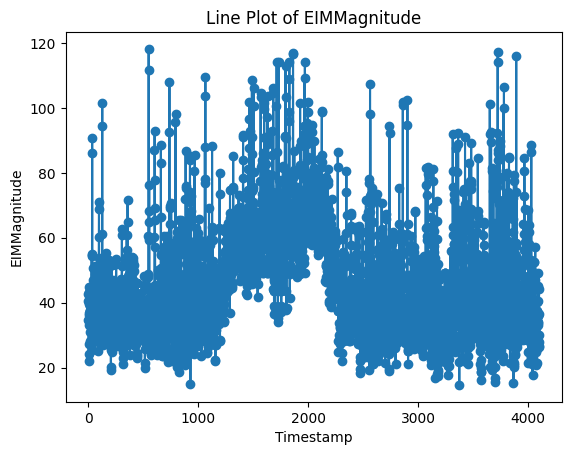

      Sample  EIMMagnitude  EIMPhase  JointAngle  Mass        Time  Timestamp  \
4023       1       42.2272  41.23580           0     0  1699875774     4023.0   
4024       1       33.0350  17.04430           0     0  1699875774     4024.0   
4025       1       23.2962  30.75780           0     0  1699875774     4025.0   
4026       1       23.0283  19.39120           0     0  1699875774     4026.0   
4027       1       27.3118   9.95016           0     0  1699875774     4027.0   
...      ...           ...       ...         ...   ...         ...        ...   
4098       1       26.6564   8.44018           0     0  1699875774     4098.0   
4099       1       27.7485   7.64391           0     0  1699875774     4099.0   
4100       1       29.8974   9.93633           0     0  1699875774     4100.0   
4101       1       36.3918  12.28430           0     0  1699875774     4101.0   
4102       1       44.2452  13.46760           0     0  1699875774     4102.0   

      InterpolatedElbowAngl

In [65]:
# Set Pandas options to display more columns
pd.options.display.max_columns=150

kinematic_data_dir = "elbow_angles.csv"
eim_data_dir = "processed_output_data.csv"

df_kin=pd.read_csv(kinematic_data_dir, encoding='utf-8', names=["ElbowAngles", "Time"])
df_kin['Timestamp'] = np.linspace(0, (len(df_kin) - 1), len(df_kin))
df_eim=pd.read_csv(eim_data_dir, encoding='utf-8')
df_eim['Timestamp'] = np.linspace(0, (len(df_eim) - 1), len(df_eim))

# Assuming df_kin is your DataFrame
df_kin['ElbowAngles'] = df_kin['ElbowAngles'].str.strip('[]').astype(float)
df_kin['Time'] = df_kin['Time'].str.strip('[]').astype(float)

# Extract kinematic timestamps and data
kinematic_timestamps = df_kin['Timestamp'].values
kinematic_data = df_kin['ElbowAngles'].values

# Assuming 'Timestamp' in df_kin is in the same time range as 'Timestamp' in df_eim
kinematic_data = df_kin['ElbowAngles'].values
kinematic_timestamps = df_kin['Timestamp'].values
eim_timestamps = df_eim['Timestamp'].values

shape = eim_timestamps.shape
kinematic_interpolated = np.empty(shape)
kin_idx = 0
step = math.floor(len(eim_timestamps)/len(kinematic_timestamps))
temp = 0

for i in range(0, len(kinematic_data), 1):
    kinematic_interpolated[kin_idx] = kinematic_data[i]
    if i < len(kinematic_data)-1:
        temp = kinematic_data[i+1]
        for j in range(kin_idx + 1, kin_idx+step, 1):
            kinematic_interpolated[j] = (kinematic_interpolated[j-1] + temp) / 2
    else:
        temp = kinematic_data[i]
        for j in range(kin_idx + 1, len(eim_timestamps), 1):
            kinematic_interpolated[j] = (kinematic_interpolated[j-1] + temp) / 2


    kin_idx = kin_idx + step


# Interpolate kinematic data to match EIM timestamps
kinematic_interpolated = interp1d(eim_timestamps, kinematic_interpolated, kind='nearest', fill_value='extrapolate')

# Create a new column in df_eim for the interpolated kinematic data
df_eim['InterpolatedElbowAngles'] = kinematic_interpolated(eim_timestamps)

# Assuming df_eim is your DataFrame
plt.plot(df_eim['Timestamp'], df_eim['InterpolatedElbowAngles'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('ElbowAngles')
plt.title('Line Plot of ElbowAngles')
plt.show()

plt.plot(df_eim['Timestamp'], df_eim['EIMMagnitude'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('EIMMagnitude')
plt.title('Line Plot of EIMMagnitude')
plt.show()

print(df_eim.tail(80))

<h3>From one csv file</h3>

In [3]:
# Set Pandas options to display more columns
pd.options.display.max_columns=150

# Google drive location weatherset: /content/drive/My Drive/Bachelor/NeuralNetwork/weatherAUS.csv
# Local weatherset location: C:/Users/Simons Lenovo/Desktop/Neural_network_data/weatherAUS.csv
data_dir = "EIM_kin_data.csv"

# Read in the data csv - keep only the columns we need
# For csv read: 
df=pd.read_csv(data_dir, encoding='utf-8', usecols=['Sample', 'EIMMagnitude', 'JointAngle'])
# df=scipy.io.loadmat(data_dir)   # Specifically for loading .mat files

# Drop records where target EIMMagnitude=NaN or JointAngle=NaN
df=df[pd.isnull(df['EIMMagnitude'])==False]
df=df[pd.isnull(df['JointAngle'])==False]

# Group the DataFrame by the 'Sample' column
grouped = df.groupby('Sample')

# Calculate the median for each group
median_values = grouped[['EIMMagnitude', 'JointAngle']].apply(lambda group: group[['EIMMagnitude', 'JointAngle']].agg(['min', 'max']).median())

# Calculate the mean for each group
mean_values = grouped[['EIMMagnitude', 'JointAngle']].mean()

# Reset the index to get the 'Sample' column back
median_values.reset_index(inplace=True)
mean_values.reset_index(inplace=True)

# Rename the columns to indicate they represent the median
median_values.columns = ['Sample', 'MedianEIMMagnitude', 'MedianJointAngle']
mean_values.columns = ['Sample', 'MeanEIMMagnitude', 'MeanJointAngle']

# Merge the median and mean values back into the original DataFrame based on the 'Sample' column
df = df.merge(median_values, on='Sample', how='left')
df = df.merge(mean_values, on='Sample', how='left')

# Show a snaphsot of data
df

,Sample,EIMMagnitude,JointAngle,MedianEIMMagnitude,MedianJointAngle,MeanEIMMagnitude,MeanJointAngle
0,1,0.170576,19.06410,0.131785,25.15580,0.127886,27.666430
1,1,0.171149,19.22470,0.131785,25.15580,0.127886,27.666430
2,1,0.171268,19.41260,0.131785,25.15580,0.127886,27.666430
3,1,0.170952,19.62800,0.131785,25.15580,0.127886,27.666430
4,1,0.170223,19.87090,0.131785,25.15580,0.127886,27.666430
...,...,...,...,...,...,...,...
22789,77,0.014896,7.03165,0.057202,6.90613,0.030544,6.606367
22790,77,0.014989,7.03163,0.057202,6.90613,0.030544,6.606367
22791,77,0.015064,7.03164,0.057202,6.90613,0.030544,6.606367
22792,77,0.015118,7.03164,0.057202,6.90613,0.030544,6.606367


<h5>Visualization</h5>

In [4]:

# Assuming your data is stored in a pandas DataFrame named 'df'
# Filter the data for the first 10 samples
df_first_10_samples = df[df['Sample'] <= 10]

# Create a scatter plot for EIMMagnitude and JointAngle
fig = go.Figure()

for sample in df_first_10_samples['Sample'].unique():
    sample_data = df_first_10_samples[df_first_10_samples['Sample'] == sample]
    fig.add_trace(go.Scatter(x=sample_data.index, y=sample_data['EIMMagnitude'],
                             mode='lines+markers', name=f'Sample {sample} - EIMMagnitude'))
    fig.add_trace(go.Scatter(x=sample_data.index, y=sample_data['JointAngle'],
                             mode='lines+markers', name=f'Sample {sample} - JointAngle'))

fig.update_layout(title='EMG and Kinematic Data for the First 10 Samples',
                  xaxis_title='Time Steps', yaxis_title='Value')

# Show the plot
fig.show()


<h1>Data preprocessing</h1>

Normalizing. Range of the scaler should be the same for x and y axis

In [5]:
# Create a copy of an original dataframe
df2=df.copy()

# Define the columns you want to normalize
columns_to_normalize = ['EIMMagnitude','JointAngle', ]

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the selected columns
df2[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Show a snaphsot of data
df2

,Sample,EIMMagnitude,JointAngle,MedianEIMMagnitude,MedianJointAngle,MeanEIMMagnitude,MeanJointAngle
0,1,0.173871,0.524417,0.131785,25.15580,0.127886,27.666430
1,1,0.174468,0.526169,0.131785,25.15580,0.127886,27.666430
2,1,0.174592,0.528218,0.131785,25.15580,0.127886,27.666430
3,1,0.174263,0.530566,0.131785,25.15580,0.127886,27.666430
4,1,0.173503,0.533215,0.131785,25.15580,0.127886,27.666430
...,...,...,...,...,...,...,...
22789,77,0.011640,0.393212,0.057202,6.90613,0.030544,6.606367
22790,77,0.011737,0.393212,0.057202,6.90613,0.030544,6.606367
22791,77,0.011815,0.393212,0.057202,6.90613,0.030544,6.606367
22792,77,0.011871,0.393212,0.057202,6.90613,0.030544,6.606367


In [6]:
# Assuming your data is stored in a pandas DataFrame named 'df'
# Filter the data for the first 10 samples
df_first_10_samples = df2[df2['Sample'] <= 10]

# Create a scatter plot for EIMMagnitude and JointAngle
fig = go.Figure()

for sample in df_first_10_samples['Sample'].unique():
    sample_data = df_first_10_samples[df_first_10_samples['Sample'] == sample]
    fig.add_trace(go.Scatter(x=sample_data.index, y=sample_data['EIMMagnitude'],
                             mode='lines+markers', name=f'Sample {sample} - EIMMagnitude'))
    fig.add_trace(go.Scatter(x=sample_data.index, y=sample_data['JointAngle'],
                             mode='lines+markers', name=f'Sample {sample} - JointAngle'))

fig.update_layout(title='EMG and Kinematic Data for the First 10 Samples',
                  xaxis_title='Time Steps', yaxis_title='Value')

# Show the plot
fig.show()

<h1>Prepare sequences for GRU</h1>

This is important for synchronizing the data with eachother with a common time variable. The "time-variable" from the dataset is therefor strictly speaking not needed for training the network.

The time_steps variable is a hyper parameter, that determines how many prior time steps the network should take into account. If time_steps=10 for example, each input sequence will contain data from the previous 10 steps, and the model will try to learn patterns based on this history.

Using a smaller number of time steps might help the model capture short-term dependencies, while a larger number could capture longer-term patterns. It's essential to experiment and choose a value that best fits the nature of the data and the task at hand.

<h3>Training and evaluating GRU model Here are a few things to highlight before we start.</h3>

**Example:** We will use sequences of 18 months to predict the average temperatures for the next 18 months. 

We will split the data into two separate dataframes — one for training and the other for validation (out of time validation).

Since we are creating a many-to-many prediction model, we need to use a slightly more complex encoder-decoder configuration. Both encoder and decoder are hidden GRU layers, with information passed from one to another via a repeat vector layer.

A repeat vector is necessary when we want to have sequences of different lengths, e.g., a sequence of 18 months to predict the next 12 months. It ensures that we provide the right shape for a decoder layer. However, if your input and output sequences are of the same length as in my example, then you can also choose to set return_sequences=True in the encoder layer and remove the repeat vector. Note that we added a Bidirectional wrapper to GRU layers. It allows us to train the model in both directions, which sometimes produces better results. However, its use is optional.

Also, we need to use a Time Distributed wrapper in the output layer to predict outputs for each timestep individually. Finally, I have used MinMaxScaling in this example because it has produced better results than the unscaled version. You can find both scaled and unscaled setups within Jupyter Notebooks in my GitHub repository (link available at the end of the article).

First, let’s define a helper function to reshape the data to a 3D array required by GRU.

In [7]:
def reshape_for_gru(datain, timestep, scaler, columns_to_use):
    X_out, Y_out = None, None

    for sample in datain['Sample'].unique():
        datatmp = datain[datain['Sample'] == sample].copy()

        for col in columns_to_use:
            arr = datatmp[col].to_numpy()

            # Scale using transform (using previously fitted scaler)
            arr_scaled = scaler.transform(arr.reshape(-1, 1)).flatten()

            cnt = 0
            for t in range(0, len(arr_scaled) - 2 * timestep + 1):
                cnt += 1
                X_start = t
                X_end = t + timestep
                Y_start = t + timestep
                Y_end = t + 2 * timestep

                if X_out is None:
                    X_out = arr_scaled[X_start:X_end].reshape(1, timestep, 1)
                    Y_out = arr_scaled[Y_start:Y_end].reshape(1, timestep, 1)
                else:
                    X_out = np.append(X_out, arr_scaled[X_start:X_end].reshape(1, timestep, 1), axis=0)
                    Y_out = np.append(Y_out, arr_scaled[Y_start:Y_end].reshape(1, timestep, 1), axis=0)

    return X_out, Y_out

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
timestep = 20

# Split data into train, eval, and test dataframes
train_ratio = 0.7
eval_ratio = 0.2
test_ratio = 0.1

# Split the data
df_train, df_temp = train_test_split(df, test_size=1 - train_ratio, random_state=42)
df_eval, df_test = train_test_split(df_temp, test_size=test_ratio / (test_ratio + eval_ratio), random_state=42)

# Use fit to train the scaler on the training data only, actual scaling will be done inside reshaping function
scaler.fit(df_train[['EIMMagnitude', 'JointAngle',]].values.reshape(-1, 1))

# Use the reshaping function to reshape the data for GRU
columns_to_use = ['EIMMagnitude', 'JointAngle']

X_train, Y_train = reshape_for_gru(df_train, timestep, scaler, columns_to_use)
X_eval, Y_eval = reshape_for_gru(df_eval, timestep, scaler, columns_to_use)
X_test, Y_test = reshape_for_gru(df_test, timestep, scaler, columns_to_use)

In [23]:
print('X_train_shape: ',X_train.shape)
print('Y_train_shape: ',Y_train.shape)
print('X_eval_shape: ',X_eval.shape)
print('Y_eval_shape: ',Y_eval.shape)
print('X_test_shape: ',X_test.shape)
print('Y_test_shape: ',Y_test.shape)

X_train_shape:  (26074, 20, 1)
Y_train_shape:  (26074, 20, 1)
X_eval_shape:  (5088, 20, 1)
Y_eval_shape:  (5088, 20, 1)
X_test_shape:  (1830, 20, 1)
Y_test_shape:  (1830, 20, 1)


The architecture you've provided is a sequence-to-sequence model based on a Bidirectional GRU (gated recurrent unit) network. It's a reasonable choice for sequence-to-sequence problems, including mapping kinematic data to EIM data. The structure of your model includes the following components:

1. **Input Layer**: This layer takes the input sequences. The shape is correctly specified as `(X_train.shape[1], X_train.shape[2])`, which matches the shape of your training data. This is suitable for the input data you have.

2. **Bidirectional GRU Encoder Layer**: This layer effectively encodes the input sequence. Using a Bidirectional GRU allows the model to capture information from both past and future time steps. The `units=32` parameter defines the number of hidden units in this layer. The choice of the number of units depends on the complexity of your problem and the amount of data. You can experiment with different values to find the best one.

3. **Repeat Vector Layer**: This layer repeats the encoded vector to match the sequence length of the output. In your case, it repeats the encoder's output sequence to match the expected sequence length of the decoder.

4. **Bidirectional GRU Decoder Layer**: This layer decodes the repeated vector into an output sequence. It also uses a Bidirectional GRU for enhanced modeling capabilities. Like the encoder, the number of `units` can be adjusted to find the best fit for your problem.

5. **TimeDistributed Dense Layer**: This layer applies a Dense layer to each time step of the sequence. The activation function is set to 'linear', which makes it suitable for regression tasks, such as predicting numerical values.

Your model architecture seems well-suited for your task. However, the effectiveness of the model depends on the specifics of your data, the problem you're solving, and the quality of the data. You may need to experiment with different hyperparameters, such as the number of units in the GRU layers, the number of layers, and the architecture of the model.

If you have additional features like mass, you can include them as additional input features in the input data. Your model can handle multiple input features. Be sure to preprocess and normalize all the input data consistently. Also, consider monitoring the training process and validating the model's performance to ensure it's learning the mapping effectively.

In [28]:
##### Step 3 - Specify the structure of a Neural Network
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(X_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

The model compilation seems reasonable for your problem. Here's a breakdown of the compilation settings:

1. **Optimizer**: You've chosen 'adam' as the optimizer. Adam is a popular and effective optimizer for training neural networks. It's known for its adaptive learning rate and tends to work well in a wide range of tasks. However, the choice of the optimizer can also depend on your specific problem and dataset. It's often a good starting point.

2. **Loss Function**: You've chosen 'mean_squared_error' as the loss function. This is a suitable choice for regression tasks, where the goal is to predict numerical values. It measures the mean of the squared differences between the predicted and actual values. The choice of loss function aligns with your problem of mapping kinematic data to EIM data.

3. **Metrics**: You've selected 'MeanSquaredError' and 'MeanAbsoluteError' as metrics. These are relevant metrics for regression tasks, helping you evaluate how well your model's predictions match the actual data. 'MeanSquaredError' measures the average of the squared differences, while 'MeanAbsoluteError' measures the average of the absolute differences.

4. **Loss Weights**: You've left this as `None`. Loss weights can be useful when you have multiple outputs with different importance levels. If your model has only one output (e.g., predicting EIM data), this isn't needed. If you have multiple outputs with varying importance, you might consider using loss weights.

5. **Weighted Metrics**: This is set to `None`. Weighted metrics are useful when different samples or classes in your data have varying importance. If you don't have specific weighting requirements, you can leave this as is.

6. **Run Eagerly**: It's set to `None`, which means it uses the default behavior. TensorFlow can compile models to a more efficient format using tf.function, but it might be necessary to disable this for some custom model logic. Leaving it as `None` is usually fine unless you run into specific issues that require disabling tf.function.

7. **Steps per Execution**: This parameter can affect performance on certain hardware, but its default value is `1`, which is suitable for most cases. It determines how many batches to run in each tf.function call. You can experiment with different values if you're optimizing for performance on specific hardware, but for general use, the default value should work.

Overall, the model compilation settings appear appropriate for your problem. However, model training and evaluation will provide better insights into its performance. You can experiment with different optimizers, loss functions, and metrics during the model's training to fine-tune its performance based on your dataset and specific requirements.

In [29]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance.
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

The parameters used in your model fit seem reasonable, but a few considerations and potential adjustments are worth noting:

1. **Batch Size**: You've set `batch_size=1`, which means you're using a batch size of 1 sample per gradient update. This can be very slow, especially if you have a large dataset. Larger batch sizes (e.g., 16, 32, or even larger) are often used to take advantage of parallel processing and speed up training. Smaller batch sizes may be suitable if you have memory constraints.

2. **Validation Split**: You've set `validation_split=0.2`, which allocates 20% of your training data for validation. This is a common practice, but you also have the option to provide explicit validation data using `validation_data=(X_test, Y_test)`. Providing explicit validation data can be helpful if you want to monitor the model's performance on a specific dataset.

3. **Epochs**: You've set `epochs=50`, which determines how many times the model will iterate over the entire training dataset. The number of epochs depends on your problem and dataset. It's a good practice to monitor the model's performance during training and stop when it no longer improves significantly.

4. **Callbacks**: You've left `callbacks` as `None`. Callbacks are powerful tools for customizing the training process. Common callbacks include early stopping, model checkpointing, and learning rate scheduling. Depending on your problem, you might want to consider using callbacks to improve training efficiency.

5. **Shuffle**: You've set `shuffle=True`, which shuffles the training data before each epoch. This is typically recommended to ensure that the model generalizes well. However, if your data has a temporal sequence (like time series data), shuffling might not be appropriate, and you may want to set `shuffle=False`.

6. **Workers and Multiprocessing**: You've set `workers=1` and `use_multiprocessing=True`. These parameters are used for generator-based data input. The number of workers can be increased to parallelize data loading if you're working with large datasets. The decision to use multiprocessing can depend on your system's capabilities.

7. **Initial Epoch**: You've set `initial_epoch=0`, which means training starts from the first epoch. If you want to continue training from a saved model or resume training from a specific point, you can set this to a different value.

8. **Validation Frequency**: You've set `validation_freq=10`, which means validation is performed every 10 epochs. This is a good practice to reduce computational overhead. Adjust this based on how frequently you want to validate your model.

The fit parameters you've provided are a good starting point. However, you may need to fine-tune some of these settings based on your specific problem and the behavior of your model during training. It's also a good practice to monitor training and validation metrics to ensure that the model is learning effectively.

In [30]:
##### Step 5 - Fit the model on the dataset
history = model.fit(X_train, # input data
                    Y_train, # target data
                    batch_size=32, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=50, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    # validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
                    validation_data=(X_eval, Y_eval), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch.
                    shuffle=False, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=10, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False.
                   )

Epoch 1/50
815/815 [==============================] - 40s 22ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0505
Epoch 2/50
815/815 [==============================] - 20s 24ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0410
Epoch 3/50
815/815 [==============================] - 20s 25ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0397
Epoch 4/50
815/815 [==============================] - 20s 25ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0395
Epoch 5/50
815/815 [==============================] - 20s 25ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0387
Epoch 6/50
815/815 [==============================] - 20s 25ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0385
Epoch 7/50
815/815 [==============================] - 20s 25ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0381
Epoch 

In [31]:
##### Step 6 - Use model to make predictions
# Predict results on training data
#pred_train = model.predict(X_train)
# Predict results on test data
pred_test = model.predict(X_test)


##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(X_test, Y_test)
print("")

58/58 [==============================] - 5s 8ms/step

-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (  (None, 64)                6720      
 Bidirectional)                                                  
                                                                 
 Repeat-Vector-Layer (Repea  (None, 20, 64)            0         
 tVector)                                                        
                                                                 
 Hidden-GRU-Decoder-Layer (  (None, 20, 64)            18816     
 Bidirectional)                                                  
                                                                 
 Output-Layer (TimeDistribu  (None, 20, 1)             65        
 ted)                                                            
             

In [32]:
pred_test = model.predict(X_test)

# Create a plot
fig = go.Figure()

# Add traces for actual values (ground truth)
for i in range(12):
    fig.add_trace(go.Scatter(x=np.arange(len(Y_test[i])), y=scaler.inverse_transform(Y_test[i].reshape(-1, 1)).flatten(),
                             mode='lines',
                             name=f'Sample {i + 1} - Actual',
                             opacity=0.8,
                             line=dict(width=1)
                            ))

# Add traces for predicted values
for i in range(12):
    fig.add_trace(go.Scatter(x=np.arange(len(pred_test[i])), y=scaler.inverse_transform(pred_test[i].reshape(-1, 1)).flatten(),
                             mode='lines',
                             name=f'Sample {i + 1} - Predicted',
                             opacity=1,
                             line=dict(width=2, dash='dot')
                            ))

# Customize the plot appearance
fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True, gridwidth=1, gridcolor='lightgrey',
        zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
        showline=True, linewidth=1, linecolor='black',
        title='Time Steps'
    ),
    yaxis=dict(
        showgrid=True, gridwidth=1, gridcolor='lightgrey',
        zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
        showline=True, linewidth=1, linecolor='black',
        title='Values'
    ),
    title=dict(text="Actual vs. Predicted Values", font=dict(color='black'))
)

# Show the plot
fig.show()

58/58 [==============================] - 0s 7ms/step


<h1>Splitting the data</h1>

Splits the data into a training/evaluation/test distribution of 70/20/10. The random_state parameter is a seed for the random split, that allows reproducability.

In [ ]:
num_kinematic_features = 18
num_emg_features = 7

# Extract X_kinematic and y_kinematic
X_kinematic = kinematic_data_normalized[:, :, :num_kinematic_features]  # Adjust num_kinematic_features
y_kinematic = kinematic_data_normalized[:, -1, :]  # Assuming the last time step represents the target

# Extract X_emg and y_emg
X_emg = emg_data_normalized[:, :, :num_emg_features]  # Adjust num_emg_features
y_emg = emg_data_normalized[:, -1, :]  # Assuming the last time step represents the target

# Now you have X_kinematic, y_kinematic, X_emg, and y_emg for further processing

# Split the data
X_kinematic_train, X_kinematic_val, y_kinematic_train, y_kinematic_val = train_test_split(
    X_kinematic, y_kinematic, test_size=0.3, random_state=42
)
X_emg_train, X_emg_val, y_emg_train, y_emg_val = train_test_split(
    X_emg, y_emg, test_size=0.3, random_state=42
)

# Ensure shapes match the model input requirements
# Add additional processing steps if necessary

# Print the shapes for verification
# print("Shapes of Kinematic Data Sets:")
# print("Train:", X_train_kinematic.shape, y_train_kinematic.shape)
# print("Validation:", X_val_kinematic.shape, y_val_kinematic.shape)
# print("Test:", X_test_kinematic.shape, y_test_kinematic.shape)

# print("\nShapes of EMG Data Sets:")
# print("Train:", X_train_emg.shape, y_train_emg.shape)
# print("Validation:", X_val_emg.shape, y_val_emg.shape)
# print("Test:", X_test_emg.shape, y_test_emg.shape)

<h1>Model architecture</h1>

**Flexibility:** Using a Seq2Seq (sequence to sequence) architecture with GRU as RNN's, since the length of the EIM signals might vary, and Seq2Seq can handle this. Normal GRU would require to truncate the samples to the same lengths. The Seq2Seq model provides more flexibility in capturing complex relationships between variable-length sequences, making it potentially more suitable for tasks where the alignment between input and output elements is not fixed.

**Attention mechanism:** The attention mechanism in the Seq2Seq model allows the network to focus on different parts of the input sequence when making predictions for each element in the output sequence. This is beneficial when the relationship between EMG signals and joint angles might not be straightforward and might require the model to attend to different segments of the input sequence.

Splits the EMG and kinematic data into two sepparate branches to train on. The idea is to create a model that can learn the relationship between EMG data and joint angles by processing both types of data during training.

During the training phase, the model learns to capture patterns and relationships between the provided EMG signals and the corresponding joint angles.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Masking, RepeatVector, Layer, Reshape
import tensorflow.keras.backend as K

# Assuming num_emg_features, num_kinematic_features, and num_joint_angle_features are defined
num_emg_features = 7
num_kinematic_features = 18

# Total number of features
num_input_features = num_emg_features + num_kinematic_features

# Define the input sequence shape
input_seq_shape = (None, num_input_features)  # Variable-length input sequence

# Define the GRU units
gru_units = 32

# EMG data branch
encoder_inputs_emg = Input(shape=(None, num_emg_features), name='Input-Layer-EMG')
encoder_emg = GRU(gru_units, return_sequences=True, name='Hidden-GRU-Encoder-Layer-EMG')(encoder_inputs_emg)

# Kinematic data branch
encoder_inputs_kinematic = Input(shape=(None, num_kinematic_features), name='Input-Layer-Kinematic')
encoder_kinematic = GRU(gru_units, return_sequences=True, name='Hidden-GRU-Encoder-Layer-Kinematic')(encoder_inputs_kinematic)

# Concatenate EMG and kinematic encodings
encoder_combined = concatenate([encoder_emg, encoder_kinematic], axis=-1)

# Attention Mechanism
attention = Dot(axes=[1, 1], name='Attention-Layer')([encoder_combined, encoder_combined])
attention = Activation('softmax', name='Attention-Activation')(attention)

# Apply attention weights to encoder outputs
context = Dot(axes=[1, 2], name='Context-Layer')([attention, encoder_combined])

# Decoder
decoder_inputs = Input(shape=(None, num_kinematic_features), name='Decoder-Input-Layer')
decoder_gru = GRU(gru_units, return_sequences=True, name='Hidden-GRU-Decoder-Layer')(decoder_inputs)

# Flatten context along with masking
context_flattened = Flatten()(Masking()(context))

# Custom layer to repeat the context along the time axis
class RepeatContextLayer(Layer):
    def __init__(self, **kwargs):
        super(RepeatContextLayer, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        return K.expand_dims(inputs, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1, input_shape[1])

context_expanded = RepeatContextLayer(name='Repeat-Context')(context_flattened)

# Concatenate expanded context and decoder GRU output
decoder_combined = Concatenate(axis=-1, name='Concatenate-Layer')([context_expanded, decoder_gru])

# Flatten the decoder_combined while maintaining the sequence length
decoder_flattened = Flatten(name='Flatten-Layer')(decoder_combined)

print('Decoder shape before reshaping: ', decoder_flattened.shape)
# Reshape to have a single dimension in the output
decoder_output = Reshape((-1, 1), name='Reshape-Layer')(decoder_flattened)
print('Flatten-Layer shape: ', decoder_output.shape)

# Output layer
outputs = TimeDistributed(Dense(1, activation='linear'), name='Output-Layer')(decoder_output)


# Create the model
model = Model(inputs=[encoder_inputs_emg, encoder_inputs_kinematic, decoder_inputs], outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary for review
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# model.fit(X_train_kinematic, y_train_kinematic, epochs=10, batch_size=32, validation_data=(X_test_kinematic, y_test_kinematic))

# Use EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model on both EMG and kinematic data
# Set the number of epochs and batch size
epochs = 10
batch_size = 32

# Training the model
model.fit(
    [X_train_emg, X_train_kinematic],  # Only EMG and kinematic inputs during training
    [y_train_kinematic, y_train_kinematic[:, 1:]],  # y_train_kinematic[:, 1:] is the shifted version for training the decoder,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_val_emg, X_val_kinematic], y_val_kinematic),  # Adjust for validation data
    callbacks=[early_stopping]  # If you are using EarlyStopping
)

# Evaluate the model on the test set
test_loss = model.evaluate([X_test_emg, X_test_kinematic], y_test_kinematic)
print(f'Test Loss: {test_loss}')

Three months are missing from the dataset, so average from preceding and subsequent months are calculated as placeholder.

In [ ]:

# Add missing months 2011-04, 2011-04, 2011-04 and impute data
df2_pivot['2011-04']=(df2_pivot['2011-03']+df2_pivot['2011-05'])/2
df2_pivot['2012-12']=(df2_pivot['2012-11']+df2_pivot['2013-01'])/2
df2_pivot['2013-02']=(df2_pivot['2013-01']+df2_pivot['2013-03'])/2

# Sort columns so Year-Months are in the correct order
df2_pivot=df2_pivot.reindex(sorted(df2_pivot.columns), axis=1)

Plots the data

In [ ]:
# %pip install nbformat

# Plot average monthly temperature derived from daily medians for each location
fig = go.Figure()
for location in df2_pivot.index:
    fig.add_trace(go.Scatter(x=df2_pivot.loc[location, :].index,
                             y=df2_pivot.loc[location, :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'), showlegend=True)

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black',
                 title='Date'
                )

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black',
                 title='Degrees Celsius'
                )

# Set figure title
fig.update_layout(title=dict(text="Average Monthly Temperatures", font=dict(color='black')))

fig.show()

Note how the mean temperature, as well as variation, differs between locations. We can either train a location-specific model for better precision or a generic model to predict temperatures for every area.

In this example, I will create a generic model trained on all locations.

Training and evaluating GRU model Here are a few things to highlight before we start.

We will use sequences of 18 months to predict the average temperatures for the next 18 months. You can adjust that to your liking but beware that there will not be enough data for sequences beyond 23 months in length.

We will split the data into two separate dataframes — one for training and the other for validation (out of time validation).

Since we are creating a many-to-many prediction model, we need to use a slightly more complex encoder-decoder configuration. Both encoder and decoder are hidden GRU layers, with information passed from one to another via a repeat vector layer.

A repeat vector is necessary when we want to have sequences of different lengths, e.g., a sequence of 18 months to predict the next 12 months. It ensures that we provide the right shape for a decoder layer. However, if your input and output sequences are of the same length as in my example, then you can also choose to set return_sequences=True in the encoder layer and remove the repeat vector. Note that we added a Bidirectional wrapper to GRU layers. It allows us to train the model in both directions, which sometimes produces better results. However, its use is optional.

Also, we need to use a Time Distributed wrapper in the output layer to predict outputs for each timestep individually. Finally, I have used MinMaxScaling in this example because it has produced better results than the unscaled version. You can find both scaled and unscaled setups within Jupyter Notebooks in my GitHub repository (link available at the end of the article).

First, let’s define a helper function to reshape the data to a 3D array required by GRU.

In [ ]:
def shaping(datain, timestep, scaler):

    # Loop through each location
    for location in datain.index:
        datatmp = datain[datain.index==location].copy()

        # Convert input dataframe to array and flatten
        arr=datatmp.to_numpy().flatten()

        # Scale using transform (using previously fitted scaler)
        arr_scaled=scaler.transform(arr.reshape(-1, 1)).flatten()

        cnt=0
        for mth in range(0, len(datatmp.columns)-(2*timestep)+1): # Define range
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.

            # Assemble input and target arrays containing all samples
            if mth==0:
                X_comb=arr_scaled[X_start:X_end]
                Y_comb=arr_scaled[Y_start:Y_end]
            else:
                X_comb=np.append(X_comb, arr_scaled[X_start:X_end])
                Y_comb=np.append(Y_comb, arr_scaled[Y_start:Y_end])

        # Reshape input and target arrays
        X_loc=np.reshape(X_comb, (cnt, timestep, 1))
        Y_loc=np.reshape(Y_comb, (cnt, timestep, 1))

        # Append an array for each location to the master array
        if location==datain.index[0]:
            X_out=X_loc
            Y_out=Y_loc
        else:
            X_out=np.concatenate((X_out, X_loc), axis=0)
            Y_out=np.concatenate((Y_out, Y_loc), axis=0)

    return X_out, Y_out

Next, we train GRU neural network over 50 epochs and display the model summary with evaluation metrics. You can follow my comments within the code to understand each step.

In [ ]:
##### Step 1 - Specify parameters
timestep=18
scaler = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
##### Step 2 - Prepare data

# Split data into train and test dataframes
df_train=df2_pivot.iloc[:, 0:-2*timestep].copy()
df_test=df2_pivot.iloc[:, -2*timestep:].copy()

# Use fit to train the scaler on the training data only, actual scaling will be done inside reshaping function
scaler.fit(df_train.to_numpy().reshape(-1, 1))

# Use previously defined shaping function to reshape the data for GRU
X_train, Y_train = shaping(datain=df_train, timestep=timestep, scaler=scaler)
X_test, Y_test = shaping(datain=df_test, timestep=timestep, scaler=scaler)

In [ ]:
##### Step 3 - Specify the structure of a Neural Network
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(X_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [ ]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance.
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

In [ ]:
##### Step 5 - Fit the model on the dataset
history = model.fit(X_train, # input data
                    Y_train, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=50, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch.
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=10, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False.
                   )

In [ ]:
##### Step 6 - Use model to make predictions
# Predict results on training data
#pred_train = model.predict(X_train)
# Predict results on test data
pred_test = model.predict(X_test)


##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(X_test, Y_test)
print("")

Now, let’s regenerate predictions for the 5 locations we picked earlier and plot the results on a chart to compare actual and predicted values

In [ ]:
# Select locations to predict temperatures for
location=['Cairns', 'Canberra', 'Darwin', 'GoldCoast', 'MountGinini']
dfloc_test = df_test[df_test.index.isin(location)].copy()

# Reshape test data
X_test, Y_test = shaping(datain=dfloc_test, timestep=timestep, scaler=scaler)

# Predict results on test data
pred_test = model.predict(X_test)

Plot results

In [ ]:
# Plot average monthly temperatures (actual and predicted) for test (out of time) data
fig = go.Figure()

# Trace for actual temperatures
for location in dfloc_test.index:
    fig.add_trace(go.Scatter(x=dfloc_test.loc[location, :].index,
                             y=dfloc_test.loc[location, :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))

# Trace for predicted temperatures
for i in range(0,pred_test.shape[0]):
    fig.add_trace(go.Scatter(x=np.array(dfloc_test.columns[-timestep:]),
                             # Need to inverse transform the predictions before plotting
                             y=scaler.inverse_transform(pred_test[i].reshape(-1,1)).flatten(),
                             mode='lines',
                             name=dfloc_test.index[i]+' Prediction',
                             opacity=1,
                             line=dict(width=2, dash='dot')
                            ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black',
                 title='Year-Month'
                )

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                 showline=True, linewidth=1, linecolor='black',
                 title='Degrees Celsius'
                )

# Set figure title
fig.update_layout(title=dict(text="Average Monthly Temperatures", font=dict(color='black')))
fig.show()